# 3層ANNによる非線形歪補償
最も基本的な、入力層・中間層・出力層からなる3層ANNによる補償

In [1]:
#import
import sys
import os
import time
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

sys.path.append('../')
from pyopt.util import save_pickle, load_pickle

# 1. Preprocessing

## 1.1 データの整形

In [2]:
def data_shaping(input_signal, signal, max_tap, tap):
    """
    input_signal: 伝送前の信号
    signal: 伝送後の信号
    max_tap: 最大の同時入力シンボル数
    tap: 同時入力シンボル数
    
    signal = [x_0, x_1, ... , x_(n-1)]
      |
      |
      v
    x = [[x_0, x_1, ... , x_tap-1],
            [x_1, x_2, ..., x_tap],
                   .
                   .
                   .
            [x_(n-tap), x_(n-tap+1), ..., x(n-1)]]
      |
      |
      v
    x = [[i_0, q_0, i_1, q_1, ... , i_(tap-1), q_(tap-1)],
            [i_1, q_1, i_2, q_2, ... , i_tap, q_tap],
                   .
                   .
                   .
            [i_(n-tap), q_(n-tap), i_(n-tap+1), q_(n-tap+1), ..., i_(n-1), q_(n-1)]] (batch, input_dim) input_dim = tap * 2
    
    y  (batch, output_dim) output_dim = 2
    """
    
    x = np.zeros((len(input_signal) - (max_tap - 1), tap * 2), dtype=float)
    y = np.zeros((len(input_signal) - (max_tap - 1), 2), dtype=float)
    for i, j in enumerate(np.arange(int((max_tap - 1) / 2), len(input_signal) - int((max_tap - 1) / 2))):
        x[i, 0::2] = signal[j - int((tap - 1) / 2): j + int((tap - 1) / 2) + 1].real
        x[i, 1::2] = signal[j - int((tap - 1) / 2): j + int((tap - 1) / 2) + 1].imag
        y[i, 0] = input_signal[j].real
        y[i, 1] = input_signal[j].imag
    return x, y

In [3]:
#動作確認
tap = 29
max_tap = 51

df_dir = '../data/input/prbs.csv'
df = pd.read_csv(df_dir, index_col=0)  # dataframe読み込み
condition = (df['N']==13) & (df['itr']==1) & (df['form']=='RZ16QAM') & (df['n']==32) & (df['equalize']==False) & (df['baudrate']==28) & (df['PdBm']==1)
sgnl = load_pickle(df[condition].iloc[0]['data_path'])  # dataframeから条件と合う行を取得し,pickleの保存先(data_path)にアクセス
lc = sgnl.linear_compensation(500, sgnl.signal['x_500'])
x, y = data_shaping(sgnl.signal['x_0'][16::32], lc[16::32], max_tap, tap)  # ANNに入力できるようにデータを整形

print('x size: ', x.shape)
print('y size: ', y.shape)

x size:  (1998, 58)
y size:  (1998, 2)


Text(0.5, 1.0, 'constellation L=500km 100%linear comp.')

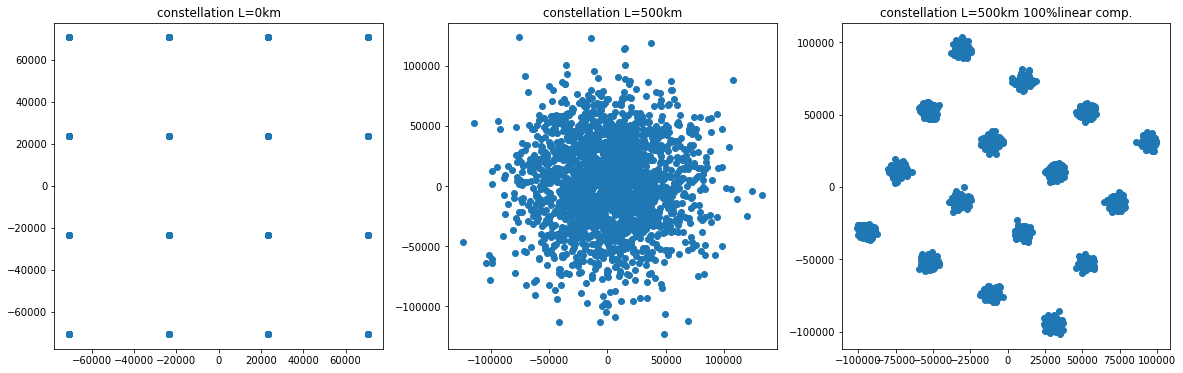

In [4]:
fig = plt.figure(figsize=(20, 6))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.plot(sgnl.signal['x_0'][16::32].real, sgnl.signal['x_0'][16::32].imag, 'o')
ax1.set_title('constellation L=0km')

ax2.plot(sgnl.signal['x_500'][16::32].real, sgnl.signal['x_500'][16::32].imag, 'o')
ax2.set_title('constellation L=500km')

ax3.plot(lc[16::32].real, lc[16::32].imag, 'o')
ax3.set_title('constellation L=500km 100%linear comp.')

## 1.2 平均,標準偏差の計算

In [5]:
mean = np.mean(x)
std = np.std(x)

print('mean: ', mean)
print('std: ', std)

mean:  1114.566034016905
std:  52135.81798093404


# 2. Dataset定義

In [6]:
class Dataset(data.Dataset):
    def __init__(self, x, y, mean, std):
        self.x, self.y, self.mean, self.std = x, y, mean, std
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        
        x = (x - self.mean) / self.std
        y = (y - self.mean) / self.std
        return torch.Tensor(x), torch.Tensor(y)

In [7]:
#動作確認
train_dataset = Dataset(x=x, y=y, mean=mean, std=std)

index = 0
x_normalized, y_normalized = train_dataset.__getitem__(index)
x_array = x_normalized.detach().numpy()

print('mean: ', np.mean(x_array))
print('std: ', np.std(x_array))
print(x_normalized)
print(y_normalized)

mean:  -0.077707395
std:  0.9639421
tensor([ 0.9693, -1.0745, -0.6699,  1.8032, -0.5759,  1.8653,  0.5698,  0.2886,
         0.1388,  1.4003,  0.5786,  0.2232, -1.5219,  0.2726, -1.4724,  0.2109,
         1.3767, -0.1905,  0.6876,  0.1550,  0.2036, -0.6009,  0.1481, -0.6349,
        -1.3982,  0.1562, -0.9955,  0.9853, -0.9983,  0.9963,  0.5785, -1.8098,
        -0.3434,  0.6310, -0.9265,  0.9492, -0.2729, -1.4374, -0.1848,  0.6101,
        -1.0056,  0.9539, -1.8427, -0.6546, -1.0626,  0.9643, -1.3433,  0.2304,
         1.8052,  0.5728,  0.9691, -0.9143, -1.8148, -0.6689, -0.6409, -0.2163,
         0.1102, -0.6393])
tensor([-1.3731,  0.4292])


In [8]:
batch_size = 100

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

dataloaders_dict = {'train': train_dataloader}

# 3. Model定義

In [9]:
class ANN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_neuron):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_neuron)
        self.fc2 = nn.Linear(hidden_neuron, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
#動作確認
hidden_neuron = 300
model = ANN(input_dim=tap*2, output_dim=2, hidden_neuron=hidden_neuron)
for x, y in train_dataloader:
    output = model(x)
    print(output[:6])
    break

tensor([[ 0.0987, -0.1069],
        [-0.0498,  0.4445],
        [-0.4864, -0.1299],
        [-0.2301,  0.1912],
        [ 0.2093,  0.0456],
        [-0.2912, -0.1845]], grad_fn=<SliceBackward>)


# 4. train定義

In [11]:
def evm_score(y_true, y_pred):
    if y_true.ndim == 2:
        y_true = y_true[:, 0] + 1j * y_true[:, 1]
        y_pred = y_pred[:, 0] + 1j * y_pred[:, 1]
    tmp = 0
    for i in range(len(y_pred)):
        tmp += abs(y_pred[i] - y_true[i]) ** 2 / abs(y_true[i]) ** 2
    evm = torch.sqrt(tmp / len(y_pred)) * 100
    return evm

In [12]:
def train_model(model, dataloaders_dict, criterion, optimizer, epochs):
    for epoch in range(epochs):
        start_time = time.time()
        
        for phase in dataloaders_dict.keys():
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            epoch_loss = 0.0
            epoch_evms = 0.0
            
            for x, y in dataloaders_dict[phase]:
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(x)
                    loss = criterion(outputs, y)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    epoch_loss += loss.item() * x.size(0)
                    epoch_evms = (evm_score(y, outputs) / 100) ** 2 * x.size(0)
            
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_evm = torch.sqrt(epoch_evms / len(dataloaders_dict[phase].dataset)) * 100
            
            duration = str(datetime.timedelta(seconds=time.time() - start_time))[:7]
            print('{} | Epoch: {}/{} | {} Loss: {:.4} | EVM: {:.4}'.format(duration, epoch + 1, epochs, phase, epoch_loss, epoch_evm))
    return model

In [13]:
#動作確認
epochs = 5
lr = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=lr)

train_model(model=model, dataloaders_dict=dataloaders_dict, criterion=criterion, optimizer=optimizer, epochs=epochs);

0:00:00 | Epoch: 1/5 | train Loss: 0.8633 | EVM: 18.41
0:00:00 | Epoch: 2/5 | train Loss: 0.4766 | EVM: 13.04
0:00:00 | Epoch: 3/5 | train Loss: 0.207 | EVM: 8.22
0:00:00 | Epoch: 4/5 | train Loss: 0.06175 | EVM: 5.013
0:00:00 | Epoch: 5/5 | train Loss: 0.02548 | EVM: 3.948


# 5. 実行

In [14]:
#結果を保存しない
tap = 1
max_tap = 501
batch_size = 100
hidden_neuron = 300
epochs = 500
lr = 0.001

df_dir = '../data/input/'
df0 = pd.read_csv(df_dir+'prbs.csv', index_col=0)

condition0 = (df0['N']==13) & (df0['itr']==1) & (df0['form']=='RZ16QAM') & (df0['n']==32) & (df0['equalize']==False) & (df0['baudrate']==28) & (df0['PdBm']==1)
sgnl0 = load_pickle(df0[condition0].iloc[0]['data_path'])
lc0 = sgnl0.linear_compensation(2500, sgnl0.signal['x_2500'])
x0, y0 = data_shaping(sgnl0.signal['x_0'][16::32], lc0[16::32], max_tap, tap)

condition1 = (df0['N']==17) & (df0['itr']==1) & (df0['form']=='RZ16QAM') & (df0['n']==32) & (df0['equalize']==False) & (df0['baudrate']==28) & (df0['PdBm']==1)
sgnl1 = load_pickle(df0[condition1].iloc[0]['data_path'])
lc1 = sgnl1.linear_compensation(2500, sgnl1.signal['x_2500'])
x1, y1 = data_shaping(sgnl1.signal['x_0'][16::32], lc1[16::32], max_tap, tap)

mean = np.mean(x0)
std = np.std(x0)

train_dataset = Dataset(x=x0, y=y0, mean=mean, std=std)
val_dataset = Dataset(x=x1, y=y1, mean=mean, std=std)

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}

model = ANN(input_dim=tap*2, output_dim=2, hidden_neuron=hidden_neuron)
criterion = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=lr)

model = train_model(model=model, dataloaders_dict=dataloaders_dict, criterion=criterion, optimizer=optimizer, epochs=epochs)

0:00:00 | Epoch: 1/500 | train Loss: 0.3018 | EVM: 4.82
0:00:02 | Epoch: 1/500 | val Loss: 0.04025 | EVM: 1.06
0:00:00 | Epoch: 2/500 | train Loss: 0.03767 | EVM: 5.025
0:00:02 | Epoch: 2/500 | val Loss: 0.04045 | EVM: 1.154
0:00:00 | Epoch: 3/500 | train Loss: 0.02446 | EVM: 3.067
0:00:02 | Epoch: 3/500 | val Loss: 0.02029 | EVM: 0.7881
0:00:00 | Epoch: 4/500 | train Loss: 0.01643 | EVM: 2.596
0:00:02 | Epoch: 4/500 | val Loss: 0.01844 | EVM: 0.789
0:00:00 | Epoch: 5/500 | train Loss: 0.01442 | EVM: 3.202
0:00:02 | Epoch: 5/500 | val Loss: 0.01728 | EVM: 0.7865
0:00:00 | Epoch: 6/500 | train Loss: 0.01382 | EVM: 2.863
0:00:02 | Epoch: 6/500 | val Loss: 0.01699 | EVM: 0.7711
0:00:00 | Epoch: 7/500 | train Loss: 0.01343 | EVM: 2.822
0:00:02 | Epoch: 7/500 | val Loss: 0.01659 | EVM: 0.7733
0:00:00 | Epoch: 8/500 | train Loss: 0.01338 | EVM: 2.307
0:00:02 | Epoch: 8/500 | val Loss: 0.0161 | EVM: 0.7718
0:00:00 | Epoch: 9/500 | train Loss: 0.0132 | EVM: 2.864
0:00:02 | Epoch: 9/500 | val L

0:00:02 | Epoch: 71/500 | val Loss: 0.008981 | EVM: 0.6753
0:00:00 | Epoch: 72/500 | train Loss: 0.006376 | EVM: 2.994
0:00:02 | Epoch: 72/500 | val Loss: 0.008267 | EVM: 0.6711
0:00:00 | Epoch: 73/500 | train Loss: 0.006278 | EVM: 2.386
0:00:02 | Epoch: 73/500 | val Loss: 0.008576 | EVM: 0.6749
0:00:00 | Epoch: 74/500 | train Loss: 0.006188 | EVM: 1.987
0:00:02 | Epoch: 74/500 | val Loss: 0.009022 | EVM: 0.6769
0:00:00 | Epoch: 75/500 | train Loss: 0.00623 | EVM: 2.235
0:00:02 | Epoch: 75/500 | val Loss: 0.008404 | EVM: 0.6705
0:00:00 | Epoch: 76/500 | train Loss: 0.006085 | EVM: 2.316
0:00:02 | Epoch: 76/500 | val Loss: 0.008129 | EVM: 0.6618
0:00:00 | Epoch: 77/500 | train Loss: 0.006104 | EVM: 2.058
0:00:02 | Epoch: 77/500 | val Loss: 0.008211 | EVM: 0.6529
0:00:00 | Epoch: 78/500 | train Loss: 0.005999 | EVM: 1.781
0:00:02 | Epoch: 78/500 | val Loss: 0.007909 | EVM: 0.6577
0:00:00 | Epoch: 79/500 | train Loss: 0.005967 | EVM: 2.103
0:00:02 | Epoch: 79/500 | val Loss: 0.007739 | EV

0:00:02 | Epoch: 140/500 | val Loss: 0.004881 | EVM: 0.5026
0:00:00 | Epoch: 141/500 | train Loss: 0.003305 | EVM: 1.564
0:00:02 | Epoch: 141/500 | val Loss: 0.004949 | EVM: 0.4978
0:00:00 | Epoch: 142/500 | train Loss: 0.003204 | EVM: 1.426
0:00:02 | Epoch: 142/500 | val Loss: 0.004754 | EVM: 0.488
0:00:00 | Epoch: 143/500 | train Loss: 0.003189 | EVM: 1.845
0:00:02 | Epoch: 143/500 | val Loss: 0.004726 | EVM: 0.4898
0:00:00 | Epoch: 144/500 | train Loss: 0.003141 | EVM: 1.506
0:00:02 | Epoch: 144/500 | val Loss: 0.004745 | EVM: 0.4844
0:00:00 | Epoch: 145/500 | train Loss: 0.003191 | EVM: 1.819
0:00:02 | Epoch: 145/500 | val Loss: 0.004804 | EVM: 0.484
0:00:00 | Epoch: 146/500 | train Loss: 0.003128 | EVM: 1.584
0:00:02 | Epoch: 146/500 | val Loss: 0.00447 | EVM: 0.4739
0:00:00 | Epoch: 147/500 | train Loss: 0.003062 | EVM: 2.234
0:00:02 | Epoch: 147/500 | val Loss: 0.004582 | EVM: 0.4853
0:00:00 | Epoch: 148/500 | train Loss: 0.003041 | EVM: 1.67
0:00:02 | Epoch: 148/500 | val Loss:

0:00:02 | Epoch: 208/500 | val Loss: 0.002679 | EVM: 0.2909
0:00:00 | Epoch: 209/500 | train Loss: 0.001444 | EVM: 1.824
0:00:02 | Epoch: 209/500 | val Loss: 0.002489 | EVM: 0.2898
0:00:00 | Epoch: 210/500 | train Loss: 0.001399 | EVM: 1.236
0:00:02 | Epoch: 210/500 | val Loss: 0.002684 | EVM: 0.2838
0:00:00 | Epoch: 211/500 | train Loss: 0.001367 | EVM: 1.234
0:00:02 | Epoch: 211/500 | val Loss: 0.00249 | EVM: 0.2807
0:00:00 | Epoch: 212/500 | train Loss: 0.001299 | EVM: 1.648
0:00:02 | Epoch: 212/500 | val Loss: 0.002462 | EVM: 0.2788
0:00:00 | Epoch: 213/500 | train Loss: 0.001338 | EVM: 1.153
0:00:02 | Epoch: 213/500 | val Loss: 0.002607 | EVM: 0.2713
0:00:00 | Epoch: 214/500 | train Loss: 0.001322 | EVM: 0.8224
0:00:02 | Epoch: 214/500 | val Loss: 0.002541 | EVM: 0.276
0:00:00 | Epoch: 215/500 | train Loss: 0.00133 | EVM: 0.89
0:00:02 | Epoch: 215/500 | val Loss: 0.002443 | EVM: 0.2798
0:00:00 | Epoch: 216/500 | train Loss: 0.001269 | EVM: 1.454
0:00:02 | Epoch: 216/500 | val Loss

0:00:00 | Epoch: 276/500 | train Loss: 0.0006974 | EVM: 0.4999
0:00:03 | Epoch: 276/500 | val Loss: 0.001653 | EVM: 0.1873
0:00:00 | Epoch: 277/500 | train Loss: 0.0006586 | EVM: 0.3114
0:00:03 | Epoch: 277/500 | val Loss: 0.001646 | EVM: 0.1845
0:00:00 | Epoch: 278/500 | train Loss: 0.0006543 | EVM: 0.8958
0:00:03 | Epoch: 278/500 | val Loss: 0.001669 | EVM: 0.1884
0:00:00 | Epoch: 279/500 | train Loss: 0.0006346 | EVM: 0.3307
0:00:03 | Epoch: 279/500 | val Loss: 0.001639 | EVM: 0.1859
0:00:00 | Epoch: 280/500 | train Loss: 0.000634 | EVM: 0.7728
0:00:03 | Epoch: 280/500 | val Loss: 0.001691 | EVM: 0.1834
0:00:00 | Epoch: 281/500 | train Loss: 0.0006761 | EVM: 0.4484
0:00:03 | Epoch: 281/500 | val Loss: 0.001735 | EVM: 0.1813
0:00:00 | Epoch: 282/500 | train Loss: 0.0006784 | EVM: 0.3925
0:00:03 | Epoch: 282/500 | val Loss: 0.001736 | EVM: 0.1764
0:00:00 | Epoch: 283/500 | train Loss: 0.0006962 | EVM: 0.592
0:00:03 | Epoch: 283/500 | val Loss: 0.001821 | EVM: 0.1804
0:00:00 | Epoch: 2

0:00:00 | Epoch: 343/500 | train Loss: 0.0005585 | EVM: 1.232
0:00:03 | Epoch: 343/500 | val Loss: 0.001452 | EVM: 0.1429
0:00:00 | Epoch: 344/500 | train Loss: 0.0004585 | EVM: 0.5369
0:00:03 | Epoch: 344/500 | val Loss: 0.001398 | EVM: 0.1427
0:00:00 | Epoch: 345/500 | train Loss: 0.0005079 | EVM: 1.407
0:00:03 | Epoch: 345/500 | val Loss: 0.001416 | EVM: 0.1426
0:00:00 | Epoch: 346/500 | train Loss: 0.0005066 | EVM: 0.2562
0:00:03 | Epoch: 346/500 | val Loss: 0.001403 | EVM: 0.1443
0:00:00 | Epoch: 347/500 | train Loss: 0.0004362 | EVM: 0.5924
0:00:03 | Epoch: 347/500 | val Loss: 0.001393 | EVM: 0.1429
0:00:00 | Epoch: 348/500 | train Loss: 0.0004529 | EVM: 0.4484
0:00:03 | Epoch: 348/500 | val Loss: 0.001364 | EVM: 0.1353
0:00:00 | Epoch: 349/500 | train Loss: 0.0004222 | EVM: 0.3246
0:00:03 | Epoch: 349/500 | val Loss: 0.001451 | EVM: 0.1321
0:00:00 | Epoch: 350/500 | train Loss: 0.0004344 | EVM: 0.673
0:00:03 | Epoch: 350/500 | val Loss: 0.001348 | EVM: 0.1311
0:00:00 | Epoch: 35

0:00:00 | Epoch: 410/500 | train Loss: 0.0003456 | EVM: 0.6989
0:00:03 | Epoch: 410/500 | val Loss: 0.001149 | EVM: 0.1181
0:00:00 | Epoch: 411/500 | train Loss: 0.0003234 | EVM: 0.5417
0:00:03 | Epoch: 411/500 | val Loss: 0.00129 | EVM: 0.1202
0:00:00 | Epoch: 412/500 | train Loss: 0.0003616 | EVM: 0.4627
0:00:03 | Epoch: 412/500 | val Loss: 0.001167 | EVM: 0.1188
0:00:00 | Epoch: 413/500 | train Loss: 0.0003481 | EVM: 1.178
0:00:03 | Epoch: 413/500 | val Loss: 0.001242 | EVM: 0.1133
0:00:00 | Epoch: 414/500 | train Loss: 0.0003262 | EVM: 0.4968
0:00:03 | Epoch: 414/500 | val Loss: 0.001164 | EVM: 0.1083
0:00:00 | Epoch: 415/500 | train Loss: 0.0003239 | EVM: 0.2337
0:00:03 | Epoch: 415/500 | val Loss: 0.001192 | EVM: 0.1225
0:00:00 | Epoch: 416/500 | train Loss: 0.0003875 | EVM: 0.2103
0:00:03 | Epoch: 416/500 | val Loss: 0.001215 | EVM: 0.1048
0:00:00 | Epoch: 417/500 | train Loss: 0.0003618 | EVM: 0.2066
0:00:03 | Epoch: 417/500 | val Loss: 0.001164 | EVM: 0.1162
0:00:00 | Epoch: 4

0:00:00 | Epoch: 477/500 | train Loss: 0.0003106 | EVM: 0.7029
0:00:03 | Epoch: 477/500 | val Loss: 0.001185 | EVM: 0.1055
0:00:00 | Epoch: 478/500 | train Loss: 0.0003181 | EVM: 0.4244
0:00:03 | Epoch: 478/500 | val Loss: 0.001126 | EVM: 0.1059
0:00:00 | Epoch: 479/500 | train Loss: 0.0002858 | EVM: 0.7229
0:00:03 | Epoch: 479/500 | val Loss: 0.001075 | EVM: 0.1038
0:00:00 | Epoch: 480/500 | train Loss: 0.0002585 | EVM: 0.8967
0:00:03 | Epoch: 480/500 | val Loss: 0.001182 | EVM: 0.1191
0:00:00 | Epoch: 481/500 | train Loss: 0.0002882 | EVM: 0.2506
0:00:03 | Epoch: 481/500 | val Loss: 0.001069 | EVM: 0.1076
0:00:00 | Epoch: 482/500 | train Loss: 0.0002941 | EVM: 0.202
0:00:03 | Epoch: 482/500 | val Loss: 0.001073 | EVM: 0.09831
0:00:00 | Epoch: 483/500 | train Loss: 0.0002623 | EVM: 0.9958
0:00:03 | Epoch: 483/500 | val Loss: 0.001145 | EVM: 0.111
0:00:00 | Epoch: 484/500 | train Loss: 0.000276 | EVM: 1.193
0:00:03 | Epoch: 484/500 | val Loss: 0.001128 | EVM: 0.1099
0:00:00 | Epoch: 48

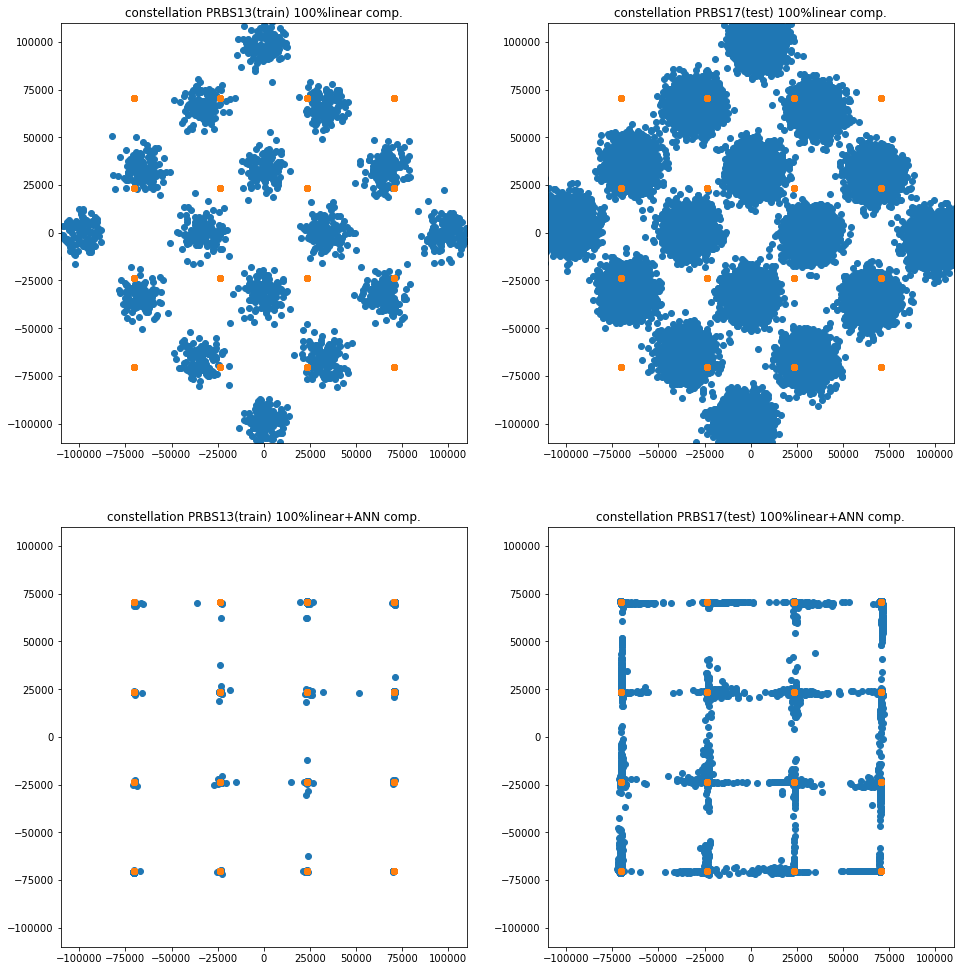

In [15]:
#可視化
annc0 = model(train_dataset[:][0]).detach().numpy()
annc0 = annc0 * std + mean
y0 = train_dataset[:][1].detach().numpy()
y0 = y0 * std + mean
annc1 = model(val_dataset[:][0]).detach().numpy()
annc1 = annc1 * std + mean
y1 = val_dataset[:][1].detach().numpy()
y1 = y1 * std + mean

lim = 110000

fig = plt.figure(figsize=(16, 17))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

ax1.plot(lc0[16::32].real, lc0[16::32].imag, 'o')
ax1.plot(y0[:, 0], y0[:, 1], 'o')
ax1.set_title('constellation PRBS13(train) 100%linear comp.')
ax1.set_xlim(-lim, lim)
ax1.set_ylim(-lim, lim)
ax2.plot(lc1[16::32].real, lc1[16::32].imag, 'o')
ax2.plot(y0[:, 0], y0[:, 1], 'o')
ax2.set_title('constellation PRBS17(test) 100%linear comp.')
ax2.set_xlim(-lim, lim)
ax2.set_ylim(-lim, lim)

ax3.plot(annc0[:, 0], annc0[:, 1], 'o')
ax3.plot(y0[:, 0], y0[:, 1], 'o')
ax3.set_title('constellation PRBS13(train) 100%linear+ANN comp.')
ax3.set_xlim(-lim, lim)
ax3.set_ylim(-lim, lim)
ax4.plot(annc1[:, 0], annc1[:, 1], 'o')
ax4.plot(y1[:, 0], y1[:, 1], 'o')
ax4.set_title('constellation PRBS17(test) 100%linear+ANN comp.')
ax4.set_xlim(-lim, lim)
ax4.set_ylim(-lim, lim);

In [16]:
#結果と条件を../data/params/ANN.csvに保存する
tap = 1
max_tap = 501
batch_size = 100
neuron = 300
epochs = 10
lr = 0.01

signal_type = 'prbs'

form = 'RZ16QAM'  # 変調方式
n = 32  # 1シンボルあたりのサンプリング数[/symbol]
equalize = False  # 各シンボル数を均等にするか
baudrate = 28  # ボーレート[GBaud]
PdBm = 1  # 平均入力光パワー[dBm]
Ledfa = 100  # EDFAスパン[km]
stepedfa = 30  # SSFMの繰り返し計算ステップ数
gamma = 1.4  # 非線形係数[/W/km]
D = 16  # 分散パラメータ[ps/nm/km]
Alpha = 0.16  # 伝送損失[dB/km]
NF = 4  # ASE雑音指数[dB]
Lmax = 2500  # 伝送距離[km]
ase = True  # ASE雑音を考慮するか

if signal_type == 'prbs':
    N = 13  # PRBSの次数
    itr = 1  # PRBSの繰り返し回数
    condition = [N, itr] + [None] * 6
elif signal_type == 'random':
    seed = 1234  # 乱数シード
    bit_num = 10000  # ビット長を指定
    condition = [None] * 2 + [seed, bit_num] + [None] * 4
elif signal_type == 'image':
    target_dir = 'train'
    step = 10  # =10 ---> (768, 1024) ---> (76, 102)
    image_number = 0
    ebtb = True  # 8B10Bを行うか
    condition = [None] * 4 + [target_dir, step, image_number, ebtb]

l_condition = 'tap=='+str(tap)+'&max_tap=='+str(max_tap)+'&batch_size=='+str(batch_size)+'&neuron=='+str(neuron)+'&learning_rate=='+str(lr)
p_condition = 'N=='+str(N)+'&itr=='+str(itr)
r_condition = 'seed=='+str(seed)+'&bit_num=='+str(bit_num)
i_condition = 'target_dir=='+str(target_dir)+'&step=='+str(step)+'&image_number='+str(image_number)+'&ebtb=='+str(ebtb)
t_condition = 'form=="'+str(form)+'"&n=='+str(n)+'&equalize=='+str(equalize)+'&baudrate=='+str(baudrate)+'&PdBm=='+str(PdBm)+'&Ledfa=='+str(Ledfa)+'&stepedfa=='+str(stepedfa)+'&\
                        gamma=='+str(gamma)+'&D=='+str(D)+'&Alpha=='+str(Alpha)+'&NF=='+str(NF)+'&Lmax=='+str(Lmax)+'&ase=='+str(ase)
    
t_df_dir = '../data/input/'
t_df = pd.read_csv(t_df_dir+signal_type+'.csv', index_col=0)

l_df_dir = '../data/params/ANN.csv'
if os.path.exists(l_df_dir):
    l_df = pd.read_csv(l_df_dir, index_col=0)
else:
    cols = ['tap', 'max_tap', 'batch_size', 'neuron', 'epochs', 'learning_rate', 'N', 'itr', 'seed', ' bit_num', 'target_dir', 'step', 'image_number', 'ebtb', 'form', 'n', 'equalize', 'baudrate', 'PdBm', 'Ledfa', 'stepedfa', 'gamma', 'D', 'Alpha', 'NF', 'Lmax', 'ase', 'params_path']
    l_df = pd.DataFrame(index=[], columns=cols)

params_path = '../data/params/ANN/params_' + str(len(l_df)).zfill(10) + '.pth'
sr = pd.Series([tap, max_tap, batch_size, neuron, epochs, lr] + condition + [form, n, equalize, baudrate, PdBm, Ledfa, stepedfa, gamma, D, Alpha, NF, Lmax, ase, params_path], index=l_df.columns)

query = l_df.query(l_condition + '&' + p_condition + '&' + t_condition)
if len(query) > 0 and query['epochs'].max() >= epochs:
    print('指定された条件の学習結果はすでに存在します')
else:
    if len(query) > 0:
        index = query['epochs'].idxmax()
        epochs -= query['epochs'][index]
        model = ANN(input_dim=tap*2, output_dim=2, hidden_neuron=neuron)
        model.load_state_dict(torch.load(query['params_path'][index]))
    else:
        model = ANN(input_dim=tap*2, output_dim=2, hidden_neuron=neuron)
    
    t_df = t_df.query(p_condition + '&' + t_condition)
    sgnl_train = load_pickle(t_df.iloc[0]['data_path'])
    lc_train = sgnl_train.linear_compensation(L, sgnl_train.signal['x_' + str(L)])
    x_train, y_train = data_shaping(sgnl_train.signal['x_0'][n//2::n], lc_train[n//2::n], max_tap, tap)

    mean = np.mean(x_train)
    std = np.std(x_train)

    train_dataset = Dataset(x=x_train, y=y_train, mean=mean, std=std)
    train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dataloaders_dict = {'train': train_dataloader}

    criterion = nn.MSELoss()
    optimizer = optim.Adam(params=model.parameters(), lr=lr)

    model = train_model(model=model, dataloaders_dict=dataloaders_dict, criterion=criterion, optimizer=optimizer, epochs=epochs)
    torch.save(model.state_dict(), params_path)

    l_df = l_df.append(sr, ignore_index=True)
    l_df.to_csv(l_df_dir)

l_df

指定された条件の学習結果はすでに存在します


,tap,max_tap,batch_size,neuron,epochs,learning_rate,N,itr,seed,bit_num,...,PdBm,Ledfa,stepedfa,gamma,D,Alpha,NF,Lmax,ase,params_path
0,1,501,100,300,10,0.001,13,1,NaN,NaN,...,1,100,30,1.4,16,0.16,4,2500,True,../data/params/ANN/params_0000000000.pth
1,1,501,100,300,20,0.001,13,1,NaN,NaN,...,1,100,30,1.4,16,0.16,4,2500,True,../data/params/ANN/params_0000000001.pth
2,1,501,100,300,10,0.010,13,1,NaN,NaN,...,1,100,30,1.4,16,0.16,4,2500,True,../data/params/ANN/params_0000000002.pth
